In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50

#Image_Size = [384, 1242]
Image_Size = [384, 1216]
#Image_Size = [384,384]
Gradient_Clipping = 0.8

#Num_Class = 31
#Num_Class = 21
Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_voting'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)

dir_checkpoint = Path(checkpoint_dir)

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 767.00it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    voting_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss


def forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']

        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels


        if model_name == 'ensemble_voting':
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
        else:
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)

    
    
    if model_name == 'ensemble_voting':
        for pred, loss in zip([unet_pred, segnet_pred, enet_pred], [unet_loss, segnet_loss, enet_loss]):
            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        return model, unet_loss, segnet_loss, enet_loss
    else:
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                
                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

                #valScore_list.append(val_score)
                #TrainLoss_list.append(loss)
                #print('Validation Dice score: {}'.format(val_score))
                                
        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:17<00:00, 14.92img/s]

***
Unet Loss: 0.5241937637329102     Segnet Loss: 0.6516222953796387     Enet Loss: 1.098189353942871
Voting Loss: 0.7580018043518066


Epoch 1/50:  99%|█████████▊| 200/203 [00:21<00:00,  9.20img/s]


---
Unet Validation Dice Score: 0.3418775200843811     Segnet Validation Dice Score: 0.34707263112068176     Enet Validation Dice Score: 0.1881972700357437
Ensemble Voting Validation Dice Loss: 1.0143709182739258
Ensemble Voting Validation Pixel Accuracy: 0.8600137275561952 
Ensemble Voting Validation MIoU: 0.5515847716666037
Ensemble Voting Validation Dice Score: 0.4399832785129547 


Epoch 2/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
Unet Loss: 0.4558517038822174     Segnet Loss: 0.39640510082244873     Enet Loss: 1.0489170551300049
Voting Loss: 0.6337246199448904


Epoch 2/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.58img/s]


---
Unet Validation Dice Score: 0.7464703917503357     Segnet Validation Dice Score: 0.7712772488594055     Enet Validation Dice Score: 0.24696378409862518
Ensemble Voting Validation Dice Loss: 0.7949450612068176
Ensemble Voting Validation Pixel Accuracy: 0.9273847613418311 
Ensemble Voting Validation MIoU: 0.782346444729162
Ensemble Voting Validation Dice Score: 0.7965795397758484 


Epoch 3/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.3847527503967285     Segnet Loss: 0.2689836621284485     Enet Loss: 0.9912331104278564
Voting Loss: 0.5483231743176779


Epoch 3/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.53img/s]


---
Unet Validation Dice Score: 0.8100547194480896     Segnet Validation Dice Score: 0.7830184102058411     Enet Validation Dice Score: 0.2835511565208435
Ensemble Voting Validation Dice Loss: 0.7014484405517578
Ensemble Voting Validation Pixel Accuracy: 0.9316524037143641 
Ensemble Voting Validation MIoU: 0.7865097879607225
Ensemble Voting Validation Dice Score: 0.7996819019317627 


Epoch 4/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.25img/s]

***
Unet Loss: 0.348120778799057     Segnet Loss: 0.22752512991428375     Enet Loss: 0.8926551342010498
Voting Loss: 0.4894336809714635


Epoch 4/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.62img/s]


---
Unet Validation Dice Score: 0.8552829623222351     Segnet Validation Dice Score: 0.7804020643234253     Enet Validation Dice Score: 0.3468438684940338
Ensemble Voting Validation Dice Loss: 0.655951976776123
Ensemble Voting Validation Pixel Accuracy: 0.9466145833333334 
Ensemble Voting Validation MIoU: 0.8252349342343415
Ensemble Voting Validation Dice Score: 0.8273265957832336 


Epoch 5/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
Unet Loss: 0.39241230487823486     Segnet Loss: 0.22718997299671173     Enet Loss: 0.7673333883285522
Voting Loss: 0.46231188873449963


Epoch 5/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.55img/s]


---
Unet Validation Dice Score: 0.8379843831062317     Segnet Validation Dice Score: 0.8444640040397644     Enet Validation Dice Score: 0.4193991720676422
Ensemble Voting Validation Dice Loss: 0.628538191318512
Ensemble Voting Validation Pixel Accuracy: 0.9430868583813048 
Ensemble Voting Validation MIoU: 0.8217874474689459
Ensemble Voting Validation Dice Score: 0.8468292355537415 


Epoch 6/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.3048752546310425     Segnet Loss: 0.13632085919380188     Enet Loss: 0.714987576007843
Voting Loss: 0.38539456327756244


Epoch 6/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.44img/s]


---
Unet Validation Dice Score: 0.8718355298042297     Segnet Validation Dice Score: 0.859479546546936     Enet Validation Dice Score: 0.484900563955307
Ensemble Voting Validation Dice Loss: 0.607710599899292
Ensemble Voting Validation Pixel Accuracy: 0.9469558983518366 
Ensemble Voting Validation MIoU: 0.8267266782716318
Ensemble Voting Validation Dice Score: 0.8738718032836914 


Epoch 7/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
Unet Loss: 0.274010568857193     Segnet Loss: 0.11768452823162079     Enet Loss: 0.6448944807052612
Voting Loss: 0.34552985926469165


Epoch 7/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]


---
Unet Validation Dice Score: 0.8636921048164368     Segnet Validation Dice Score: 0.8706246614456177     Enet Validation Dice Score: 0.5523226261138916
Ensemble Voting Validation Dice Loss: 0.5916363000869751
Ensemble Voting Validation Pixel Accuracy: 0.9434014035944354 
Ensemble Voting Validation MIoU: 0.8223555988211414
Ensemble Voting Validation Dice Score: 0.8773290514945984 


Epoch 8/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
Unet Loss: 0.2758515179157257     Segnet Loss: 0.16182339191436768     Enet Loss: 0.6446449756622314
Voting Loss: 0.3607732951641083


Epoch 8/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.42img/s]


---
Unet Validation Dice Score: 0.8814994096755981     Segnet Validation Dice Score: 0.8618502616882324     Enet Validation Dice Score: 0.6203758120536804
Ensemble Voting Validation Dice Loss: 0.5683385133743286
Ensemble Voting Validation Pixel Accuracy: 0.9559821413274396 
Ensemble Voting Validation MIoU: 0.8531713870716486
Ensemble Voting Validation Dice Score: 0.8788990378379822 


Epoch 9/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.11img/s]

***
Unet Loss: 0.2369789332151413     Segnet Loss: 0.11609399318695068     Enet Loss: 0.581963300704956
Voting Loss: 0.311678742369016


Epoch 9/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.51img/s]


---
Unet Validation Dice Score: 0.8656889796257019     Segnet Validation Dice Score: 0.8716927766799927     Enet Validation Dice Score: 0.683804988861084
Ensemble Voting Validation Dice Loss: 0.5582208633422852
Ensemble Voting Validation Pixel Accuracy: 0.9526257431297972 
Ensemble Voting Validation MIoU: 0.8445815286871716
Ensemble Voting Validation Dice Score: 0.874344527721405 


Epoch 10/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
Unet Loss: 0.24115990102291107     Segnet Loss: 0.1351056545972824     Enet Loss: 0.5425064563751221
Voting Loss: 0.30625733733177185


Epoch 10/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.46img/s]


---
Unet Validation Dice Score: 0.8684073686599731     Segnet Validation Dice Score: 0.8841748237609863     Enet Validation Dice Score: 0.7527167201042175
Ensemble Voting Validation Dice Loss: 0.5404813289642334
Ensemble Voting Validation Pixel Accuracy: 0.9524303235505757 
Ensemble Voting Validation MIoU: 0.8405882790736244
Ensemble Voting Validation Dice Score: 0.889653205871582 


Epoch 11/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.06img/s]

***
Unet Loss: 0.20681323111057281     Segnet Loss: 0.10370263457298279     Enet Loss: 0.5173579454421997
Voting Loss: 0.27595793704191846


Epoch 11/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.50img/s]


---
Unet Validation Dice Score: 0.856006920337677     Segnet Validation Dice Score: 0.882825493812561     Enet Validation Dice Score: 0.7953852415084839
Ensemble Voting Validation Dice Loss: 0.535393476486206
Ensemble Voting Validation Pixel Accuracy: 0.9490353768331963 
Ensemble Voting Validation MIoU: 0.8381003866398603
Ensemble Voting Validation Dice Score: 0.881955623626709 


Epoch 12/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
Unet Loss: 0.18806979060173035     Segnet Loss: 0.07613478600978851     Enet Loss: 0.48133936524391174
Voting Loss: 0.24851464728514353


Epoch 12/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.38img/s]


---
Unet Validation Dice Score: 0.9000990986824036     Segnet Validation Dice Score: 0.8959607481956482     Enet Validation Dice Score: 0.7963632345199585
Ensemble Voting Validation Dice Loss: 0.5207818150520325
Ensemble Voting Validation Pixel Accuracy: 0.959804334138569 
Ensemble Voting Validation MIoU: 0.8632658986102305
Ensemble Voting Validation Dice Score: 0.9034284949302673 


Epoch 13/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.08img/s]

***
Unet Loss: 0.18104450404644012     Segnet Loss: 0.0681304931640625     Enet Loss: 0.5027223825454712
Voting Loss: 0.25063245991865796


Epoch 13/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.51img/s]


---
Unet Validation Dice Score: 0.8981332182884216     Segnet Validation Dice Score: 0.9025190472602844     Enet Validation Dice Score: 0.800887405872345
Ensemble Voting Validation Dice Loss: 0.5152647495269775
Ensemble Voting Validation Pixel Accuracy: 0.9616466321443257 
Ensemble Voting Validation MIoU: 0.8682709262156543
Ensemble Voting Validation Dice Score: 0.9070382118225098 


Epoch 14/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.42img/s]

***
Unet Loss: 0.21379150450229645     Segnet Loss: 0.07442499697208405     Enet Loss: 0.4889020025730133
Voting Loss: 0.2590395013491313


Epoch 14/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.62img/s]


---
Unet Validation Dice Score: 0.8989999890327454     Segnet Validation Dice Score: 0.8970069289207458     Enet Validation Dice Score: 0.8010651469230652
Ensemble Voting Validation Dice Loss: 0.5164313912391663
Ensemble Voting Validation Pixel Accuracy: 0.9578902930544134 
Ensemble Voting Validation MIoU: 0.8599082303895558
Ensemble Voting Validation Dice Score: 0.8999932408332825 


Epoch 15/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
Unet Loss: 0.18081045150756836     Segnet Loss: 0.06576425582170486     Enet Loss: 0.46206235885620117
Voting Loss: 0.23621235539515814


Epoch 15/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.46img/s]


---
Unet Validation Dice Score: 0.9007488489151001     Segnet Validation Dice Score: 0.9011005759239197     Enet Validation Dice Score: 0.8026379942893982
Ensemble Voting Validation Dice Loss: 0.5149248242378235
Ensemble Voting Validation Pixel Accuracy: 0.9576250042831689 
Ensemble Voting Validation MIoU: 0.8589569231832881
Ensemble Voting Validation Dice Score: 0.9016650319099426 


Epoch 16/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
Unet Loss: 0.17479920387268066     Segnet Loss: 0.05861017480492592     Enet Loss: 0.44997844099998474
Voting Loss: 0.22779593989253044


Epoch 16/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.45img/s]


---
Unet Validation Dice Score: 0.9013535380363464     Segnet Validation Dice Score: 0.901848316192627     Enet Validation Dice Score: 0.80279141664505
Ensemble Voting Validation Dice Loss: 0.5133997797966003
Ensemble Voting Validation Pixel Accuracy: 0.9606023420367324 
Ensemble Voting Validation MIoU: 0.8669407591064324
Ensemble Voting Validation Dice Score: 0.906251072883606 


Epoch 17/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.81img/s]

***
Unet Loss: 0.18437407910823822     Segnet Loss: 0.05862552300095558     Enet Loss: 0.47755762934684753
Voting Loss: 0.24018574381868044


Epoch 17/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]


---
Unet Validation Dice Score: 0.8974979519844055     Segnet Validation Dice Score: 0.9002593159675598     Enet Validation Dice Score: 0.8037061095237732
Ensemble Voting Validation Dice Loss: 0.5150504112243652
Ensemble Voting Validation Pixel Accuracy: 0.9575709292763158 
Ensemble Voting Validation MIoU: 0.8585138009702001
Ensemble Voting Validation Dice Score: 0.9040455222129822 


Epoch 18/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.04img/s]

***
Unet Loss: 0.17606359720230103     Segnet Loss: 0.057970453053712845     Enet Loss: 0.47836288809776306
Voting Loss: 0.23746564611792564


Epoch 18/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.53img/s]


---
Unet Validation Dice Score: 0.8970438838005066     Segnet Validation Dice Score: 0.9049875140190125     Enet Validation Dice Score: 0.8061498999595642
Ensemble Voting Validation Dice Loss: 0.5089241862297058
Ensemble Voting Validation Pixel Accuracy: 0.9637261106256854 
Ensemble Voting Validation MIoU: 0.8753245887640719
Ensemble Voting Validation Dice Score: 0.9077616930007935 


Epoch 19/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.06img/s]

***
Unet Loss: 0.1712285429239273     Segnet Loss: 0.052942268550395966     Enet Loss: 0.452523797750473
Voting Loss: 0.22556486974159876


Epoch 19/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]


---
Unet Validation Dice Score: 0.8936802744865417     Segnet Validation Dice Score: 0.9025710225105286     Enet Validation Dice Score: 0.8083650469779968
Ensemble Voting Validation Dice Loss: 0.5069773197174072
Ensemble Voting Validation Pixel Accuracy: 0.9638960988898027 
Ensemble Voting Validation MIoU: 0.8753873259102812
Ensemble Voting Validation Dice Score: 0.906050980091095 


Epoch 20/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
Unet Loss: 0.1712970733642578     Segnet Loss: 0.04827018454670906     Enet Loss: 0.48967164754867554
Voting Loss: 0.23641296848654747


Epoch 20/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.53img/s]


---
Unet Validation Dice Score: 0.8975057005882263     Segnet Validation Dice Score: 0.9042224287986755     Enet Validation Dice Score: 0.8078781366348267
Ensemble Voting Validation Dice Loss: 0.507250964641571
Ensemble Voting Validation Pixel Accuracy: 0.9643174556263706 
Ensemble Voting Validation MIoU: 0.8767462277532921
Ensemble Voting Validation Dice Score: 0.9078220725059509 


Epoch 21/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.07img/s]

***
Unet Loss: 0.20075635612010956     Segnet Loss: 0.070647232234478     Enet Loss: 0.4870172142982483
Voting Loss: 0.25280693421761197


Epoch 21/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]


---
Unet Validation Dice Score: 0.8996204733848572     Segnet Validation Dice Score: 0.9026848077774048     Enet Validation Dice Score: 0.8065710067749023
Ensemble Voting Validation Dice Loss: 0.5111705660820007
Ensemble Voting Validation Pixel Accuracy: 0.9597390158134594 
Ensemble Voting Validation MIoU: 0.8647274716456423
Ensemble Voting Validation Dice Score: 0.9052796363830566 


Epoch 22/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.02img/s]

***
Unet Loss: 0.1614946722984314     Segnet Loss: 0.05817895755171776     Enet Loss: 0.49046528339385986
Voting Loss: 0.23671297108133635


Epoch 22/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.55img/s]


---
Unet Validation Dice Score: 0.8994766473770142     Segnet Validation Dice Score: 0.9025678038597107     Enet Validation Dice Score: 0.807806134223938
Ensemble Voting Validation Dice Loss: 0.508590817451477
Ensemble Voting Validation Pixel Accuracy: 0.961919951857182 
Ensemble Voting Validation MIoU: 0.8688381133358276
Ensemble Voting Validation Dice Score: 0.9079664349555969 


Epoch 23/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.35img/s]

***
Unet Loss: 0.18643543124198914     Segnet Loss: 0.07456175982952118     Enet Loss: 0.47915300726890564
Voting Loss: 0.24671673278013864


Epoch 23/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.55img/s]


---
Unet Validation Dice Score: 0.9024702906608582     Segnet Validation Dice Score: 0.9057148098945618     Enet Validation Dice Score: 0.8058905005455017
Ensemble Voting Validation Dice Loss: 0.5082559585571289
Ensemble Voting Validation Pixel Accuracy: 0.963705765573602 
Ensemble Voting Validation MIoU: 0.8751757457887837
Ensemble Voting Validation Dice Score: 0.9087681174278259 


Epoch 24/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.26img/s]

***
Unet Loss: 0.18353503942489624     Segnet Loss: 0.061094239354133606     Enet Loss: 0.49214044213294983
Voting Loss: 0.24558990697065988


Epoch 24/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.56img/s]


---
Unet Validation Dice Score: 0.9008990526199341     Segnet Validation Dice Score: 0.9025114178657532     Enet Validation Dice Score: 0.8059078454971313
Ensemble Voting Validation Dice Loss: 0.5124492645263672
Ensemble Voting Validation Pixel Accuracy: 0.9592065643845943 
Ensemble Voting Validation MIoU: 0.8636955545951486
Ensemble Voting Validation Dice Score: 0.9052237868309021 


Epoch 25/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.19img/s]

***
Unet Loss: 0.16576451063156128     Segnet Loss: 0.05310676991939545     Enet Loss: 0.4459024965763092
Voting Loss: 0.22159125904242197


Epoch 25/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.45img/s]


---
Unet Validation Dice Score: 0.8984250426292419     Segnet Validation Dice Score: 0.9039959907531738     Enet Validation Dice Score: 0.8068410158157349
Ensemble Voting Validation Dice Loss: 0.5083532333374023
Ensemble Voting Validation Pixel Accuracy: 0.9634533263089364 
Ensemble Voting Validation MIoU: 0.8735075688113783
Ensemble Voting Validation Dice Score: 0.9083254933357239 


Epoch 26/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.02img/s]

***
Unet Loss: 0.166659876704216     Segnet Loss: 0.049922022968530655     Enet Loss: 0.4437660574913025
Voting Loss: 0.22011598572134972


Epoch 26/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.43img/s]


---
Unet Validation Dice Score: 0.9008852243423462     Segnet Validation Dice Score: 0.9041053056716919     Enet Validation Dice Score: 0.8056719899177551
Ensemble Voting Validation Dice Loss: 0.5107545852661133
Ensemble Voting Validation Pixel Accuracy: 0.9612619500411185 
Ensemble Voting Validation MIoU: 0.8682449876716867
Ensemble Voting Validation Dice Score: 0.907747209072113 


Epoch 27/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.17img/s]

***
Unet Loss: 0.17274600267410278     Segnet Loss: 0.05638108402490616     Enet Loss: 0.4409366846084595
Voting Loss: 0.22335459043582281


Epoch 27/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.55img/s]


---
Unet Validation Dice Score: 0.9027239084243774     Segnet Validation Dice Score: 0.9005278944969177     Enet Validation Dice Score: 0.8073256611824036
Ensemble Voting Validation Dice Loss: 0.5136939287185669
Ensemble Voting Validation Pixel Accuracy: 0.9576236657929003 
Ensemble Voting Validation MIoU: 0.8586391359272627
Ensemble Voting Validation Dice Score: 0.9040889739990234 


Epoch 28/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
Unet Loss: 0.17556770145893097     Segnet Loss: 0.053721893578767776     Enet Loss: 0.45499467849731445
Voting Loss: 0.2280947578450044


Epoch 28/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.49img/s]


---
Unet Validation Dice Score: 0.9017404913902283     Segnet Validation Dice Score: 0.9050999879837036     Enet Validation Dice Score: 0.8074843287467957
Ensemble Voting Validation Dice Loss: 0.5104802846908569
Ensemble Voting Validation Pixel Accuracy: 0.9613435979475055 
Ensemble Voting Validation MIoU: 0.8684478047636262
Ensemble Voting Validation Dice Score: 0.9085097312927246 


Epoch 29/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.04img/s]

***
Unet Loss: 0.16261574625968933     Segnet Loss: 0.050407785922288895     Enet Loss: 0.46364063024520874
Voting Loss: 0.22555472080906233


Epoch 29/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.50img/s]


---
Unet Validation Dice Score: 0.901013195514679     Segnet Validation Dice Score: 0.9049962162971497     Enet Validation Dice Score: 0.8048637509346008
Ensemble Voting Validation Dice Loss: 0.5104180574417114
Ensemble Voting Validation Pixel Accuracy: 0.9621234023780153 
Ensemble Voting Validation MIoU: 0.8705470502651991
Ensemble Voting Validation Dice Score: 0.9084989428520203 


Epoch 30/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.07img/s]

***
Unet Loss: 0.18222567439079285     Segnet Loss: 0.060528714209795     Enet Loss: 0.46371546387672424
Voting Loss: 0.2354899508257707


Epoch 30/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.34img/s]


---
Unet Validation Dice Score: 0.9029577374458313     Segnet Validation Dice Score: 0.8996705412864685     Enet Validation Dice Score: 0.8064524531364441
Ensemble Voting Validation Dice Loss: 0.5140421390533447
Ensemble Voting Validation Pixel Accuracy: 0.9572057891310307 
Ensemble Voting Validation MIoU: 0.8587246072367238
Ensemble Voting Validation Dice Score: 0.9025371670722961 


Epoch 31/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.18img/s]

***
Unet Loss: 0.17754510045051575     Segnet Loss: 0.05692111328244209     Enet Loss: 0.423068106174469
Voting Loss: 0.21917810663580894


Epoch 31/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.46img/s]


---
Unet Validation Dice Score: 0.902010440826416     Segnet Validation Dice Score: 0.903378963470459     Enet Validation Dice Score: 0.8065322041511536
Ensemble Voting Validation Dice Loss: 0.5089375972747803
Ensemble Voting Validation Pixel Accuracy: 0.9628092447916666 
Ensemble Voting Validation MIoU: 0.872636154685584
Ensemble Voting Validation Dice Score: 0.9070897102355957 


Epoch 32/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.82img/s]

***
Unet Loss: 0.16752786934375763     Segnet Loss: 0.057841408997774124     Enet Loss: 0.4915684461593628
Voting Loss: 0.23897924150029817


Epoch 32/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]


---
Unet Validation Dice Score: 0.9008859992027283     Segnet Validation Dice Score: 0.9044414758682251     Enet Validation Dice Score: 0.8078892827033997
Ensemble Voting Validation Dice Loss: 0.5048424005508423
Ensemble Voting Validation Pixel Accuracy: 0.9653454161526864 
Ensemble Voting Validation MIoU: 0.8787004121895898
Ensemble Voting Validation Dice Score: 0.9093158841133118 


Epoch 33/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.04img/s]

***
Unet Loss: 0.19042783975601196     Segnet Loss: 0.07587108016014099     Enet Loss: 0.5127331018447876
Voting Loss: 0.25967734058698017


Epoch 33/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.41img/s]


---
Unet Validation Dice Score: 0.9002676010131836     Segnet Validation Dice Score: 0.9026470184326172     Enet Validation Dice Score: 0.8060489892959595
Ensemble Voting Validation Dice Loss: 0.5108486413955688
Ensemble Voting Validation Pixel Accuracy: 0.9608100757264254 
Ensemble Voting Validation MIoU: 0.8677375307630476
Ensemble Voting Validation Dice Score: 0.9056727290153503 


Epoch 34/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.10img/s]

***
Unet Loss: 0.16073492169380188     Segnet Loss: 0.05553482472896576     Enet Loss: 0.4760824739933014
Voting Loss: 0.230784073472023


Epoch 34/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.44img/s]


---
Unet Validation Dice Score: 0.9014272093772888     Segnet Validation Dice Score: 0.9056183695793152     Enet Validation Dice Score: 0.8063783049583435
Ensemble Voting Validation Dice Loss: 0.5078133940696716
Ensemble Voting Validation Pixel Accuracy: 0.9633708753083882 
Ensemble Voting Validation MIoU: 0.8741976142832897
Ensemble Voting Validation Dice Score: 0.9094386100769043 


Epoch 35/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
Unet Loss: 0.1850968301296234     Segnet Loss: 0.07569113373756409     Enet Loss: 0.4556156098842621
Voting Loss: 0.23880119125048319


Epoch 35/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.42img/s]


---
Unet Validation Dice Score: 0.9036363959312439     Segnet Validation Dice Score: 0.9026276469230652     Enet Validation Dice Score: 0.8050899505615234
Ensemble Voting Validation Dice Loss: 0.5120611190795898
Ensemble Voting Validation Pixel Accuracy: 0.959448028029057 
Ensemble Voting Validation MIoU: 0.8633518434828653
Ensemble Voting Validation Dice Score: 0.9061675071716309 


Epoch 36/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
Unet Loss: 0.15685591101646423     Segnet Loss: 0.04667329043149948     Enet Loss: 0.44594231247901917
Voting Loss: 0.21649050464232764


Epoch 36/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.46img/s]


---
Unet Validation Dice Score: 0.9018241763114929     Segnet Validation Dice Score: 0.9066583514213562     Enet Validation Dice Score: 0.8062028288841248
Ensemble Voting Validation Dice Loss: 0.509941816329956
Ensemble Voting Validation Pixel Accuracy: 0.9609717653508771 
Ensemble Voting Validation MIoU: 0.8666926672419044
Ensemble Voting Validation Dice Score: 0.9104709625244141 


Epoch 37/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.80img/s]

***
Unet Loss: 0.17176680266857147     Segnet Loss: 0.06088336557149887     Enet Loss: 0.44202953577041626
Voting Loss: 0.2248932346701622


Epoch 37/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.46img/s]


---
Unet Validation Dice Score: 0.9033429026603699     Segnet Validation Dice Score: 0.9019326567649841     Enet Validation Dice Score: 0.8082443475723267
Ensemble Voting Validation Dice Loss: 0.5112003684043884
Ensemble Voting Validation Pixel Accuracy: 0.9597542746025219 
Ensemble Voting Validation MIoU: 0.8641477530950734
Ensemble Voting Validation Dice Score: 0.9063140749931335 


Epoch 38/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
Unet Loss: 0.16268855333328247     Segnet Loss: 0.048242390155792236     Enet Loss: 0.46020200848579407
Voting Loss: 0.22371098399162292


Epoch 38/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.49img/s]


---
Unet Validation Dice Score: 0.8980926871299744     Segnet Validation Dice Score: 0.9051932692527771     Enet Validation Dice Score: 0.8077287077903748
Ensemble Voting Validation Dice Loss: 0.505501389503479
Ensemble Voting Validation Pixel Accuracy: 0.965725815087034 
Ensemble Voting Validation MIoU: 0.8801145272059916
Ensemble Voting Validation Dice Score: 0.9094889760017395 


Epoch 39/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
Unet Loss: 0.22811710834503174     Segnet Loss: 0.10008065402507782     Enet Loss: 0.49911242723464966
Voting Loss: 0.2757700632015864


Epoch 39/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.39img/s]


---
Unet Validation Dice Score: 0.899331271648407     Segnet Validation Dice Score: 0.9042804837226868     Enet Validation Dice Score: 0.808922290802002
Ensemble Voting Validation Dice Loss: 0.5073684453964233
Ensemble Voting Validation Pixel Accuracy: 0.9635424697608278 
Ensemble Voting Validation MIoU: 0.8746676742893054
Ensemble Voting Validation Dice Score: 0.9073901176452637 


Epoch 40/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.86img/s]

***
Unet Loss: 0.1782936006784439     Segnet Loss: 0.058768920600414276     Enet Loss: 0.4815405607223511
Voting Loss: 0.23953436066706976


Epoch 40/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.55img/s]


---
Unet Validation Dice Score: 0.902503490447998     Segnet Validation Dice Score: 0.9048886299133301     Enet Validation Dice Score: 0.806484043598175
Ensemble Voting Validation Dice Loss: 0.5104458332061768
Ensemble Voting Validation Pixel Accuracy: 0.9611297072025767 
Ensemble Voting Validation MIoU: 0.8674375450051734
Ensemble Voting Validation Dice Score: 0.9084920883178711 


Epoch 41/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
Unet Loss: 0.20495620369911194     Segnet Loss: 0.07656709849834442     Enet Loss: 0.5189485549926758
Voting Loss: 0.2668239523967107


Epoch 41/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.46img/s]


---
Unet Validation Dice Score: 0.9012859463691711     Segnet Validation Dice Score: 0.9056127667427063     Enet Validation Dice Score: 0.8079273104667664
Ensemble Voting Validation Dice Loss: 0.5093324184417725
Ensemble Voting Validation Pixel Accuracy: 0.9617504989891722 
Ensemble Voting Validation MIoU: 0.869664745839281
Ensemble Voting Validation Dice Score: 0.9080399870872498 


Epoch 42/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
Unet Loss: 0.15218932926654816     Segnet Loss: 0.0511600524187088     Enet Loss: 0.4710632562637329
Voting Loss: 0.2248042126496633


Epoch 42/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.55img/s]


---
Unet Validation Dice Score: 0.9026246070861816     Segnet Validation Dice Score: 0.9055078625679016     Enet Validation Dice Score: 0.8079824447631836
Ensemble Voting Validation Dice Loss: 0.5088452100753784
Ensemble Voting Validation Pixel Accuracy: 0.9622347647683662 
Ensemble Voting Validation MIoU: 0.8704209107094399
Ensemble Voting Validation Dice Score: 0.9092859625816345 


Epoch 43/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.04img/s]

***
Unet Loss: 0.17894525825977325     Segnet Loss: 0.06652549654245377     Enet Loss: 0.4656040370464325
Voting Loss: 0.23702493061621985


Epoch 43/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.60img/s]


---
Unet Validation Dice Score: 0.9015585780143738     Segnet Validation Dice Score: 0.9073010683059692     Enet Validation Dice Score: 0.8077824711799622
Ensemble Voting Validation Dice Loss: 0.5071631669998169
Ensemble Voting Validation Pixel Accuracy: 0.9637194181743421 
Ensemble Voting Validation MIoU: 0.8752544705417089
Ensemble Voting Validation Dice Score: 0.9091200828552246 


Epoch 44/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.21img/s]

***
Unet Loss: 0.16673064231872559     Segnet Loss: 0.05438988655805588     Enet Loss: 0.4372949004173279
Voting Loss: 0.21947180976470312


Epoch 44/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.45img/s]


---
Unet Validation Dice Score: 0.9027999043464661     Segnet Validation Dice Score: 0.9023893475532532     Enet Validation Dice Score: 0.8075842261314392
Ensemble Voting Validation Dice Loss: 0.5103867053985596
Ensemble Voting Validation Pixel Accuracy: 0.9602529960766173 
Ensemble Voting Validation MIoU: 0.8659195611430164
Ensemble Voting Validation Dice Score: 0.9060763716697693 


Epoch 45/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
Unet Loss: 0.17820605635643005     Segnet Loss: 0.05895328149199486     Enet Loss: 0.4583400785923004
Voting Loss: 0.23183313881357512


Epoch 45/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.30img/s]


---
Unet Validation Dice Score: 0.9033617377281189     Segnet Validation Dice Score: 0.9055562019348145     Enet Validation Dice Score: 0.8066065907478333
Ensemble Voting Validation Dice Loss: 0.5104979276657104
Ensemble Voting Validation Pixel Accuracy: 0.9621086789850604 
Ensemble Voting Validation MIoU: 0.8714275142587156
Ensemble Voting Validation Dice Score: 0.9076318740844727 


Epoch 46/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.86img/s]

***
Unet Loss: 0.178645521402359     Segnet Loss: 0.06852678954601288     Enet Loss: 0.47937679290771484
Voting Loss: 0.2421830346186956


Epoch 46/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.50img/s]


---
Unet Validation Dice Score: 0.9022358059883118     Segnet Validation Dice Score: 0.9059896469116211     Enet Validation Dice Score: 0.8061599731445312
Ensemble Voting Validation Dice Loss: 0.5094372034072876
Ensemble Voting Validation Pixel Accuracy: 0.9615366082442435 
Ensemble Voting Validation MIoU: 0.8688571989911629
Ensemble Voting Validation Dice Score: 0.9088324904441833 


Epoch 47/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.40img/s]

***
Unet Loss: 0.19995462894439697     Segnet Loss: 0.0642799511551857     Enet Loss: 0.4895056188106537
Voting Loss: 0.25124673297007877


Epoch 47/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.51img/s]


---
Unet Validation Dice Score: 0.9025656580924988     Segnet Validation Dice Score: 0.9016143083572388     Enet Validation Dice Score: 0.8055457472801208
Ensemble Voting Validation Dice Loss: 0.5116034150123596
Ensemble Voting Validation Pixel Accuracy: 0.9599060593989858 
Ensemble Voting Validation MIoU: 0.8650888724030761
Ensemble Voting Validation Dice Score: 0.9046000838279724 


Epoch 48/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.47img/s]

***
Unet Loss: 0.18423211574554443     Segnet Loss: 0.06778918206691742     Enet Loss: 0.47572851181030273
Voting Loss: 0.24258326987425485


Epoch 48/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.58img/s]


---
Unet Validation Dice Score: 0.9019234776496887     Segnet Validation Dice Score: 0.90314120054245     Enet Validation Dice Score: 0.804835319519043
Ensemble Voting Validation Dice Loss: 0.511599063873291
Ensemble Voting Validation Pixel Accuracy: 0.9607782196580318 
Ensemble Voting Validation MIoU: 0.8672937131524687
Ensemble Voting Validation Dice Score: 0.906718909740448 


Epoch 49/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.48img/s]

***
Unet Loss: 0.1738947480916977     Segnet Loss: 0.06449857354164124     Enet Loss: 0.4947114586830139
Voting Loss: 0.24436826010545096


Epoch 49/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.59img/s]


---
Unet Validation Dice Score: 0.9029203653335571     Segnet Validation Dice Score: 0.905670166015625     Enet Validation Dice Score: 0.8066331744194031
Ensemble Voting Validation Dice Loss: 0.5090638399124146
Ensemble Voting Validation Pixel Accuracy: 0.9619686729029605 
Ensemble Voting Validation MIoU: 0.8698684720972486
Ensemble Voting Validation Dice Score: 0.90919029712677 


Epoch 50/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.04img/s]

***
Unet Loss: 0.169923335313797     Segnet Loss: 0.0537806935608387     Enet Loss: 0.480141282081604
Voting Loss: 0.2346151036520799


Epoch 50/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.36img/s]

---
Unet Validation Dice Score: 0.8992828726768494     Segnet Validation Dice Score: 0.9064558148384094     Enet Validation Dice Score: 0.8090044260025024
Ensemble Voting Validation Dice Loss: 0.5061138868331909
Ensemble Voting Validation Pixel Accuracy: 0.9649671588027686 
Ensemble Voting Validation MIoU: 0.8783769845032658
Ensemble Voting Validation Dice Score: 0.9098684191703796 


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

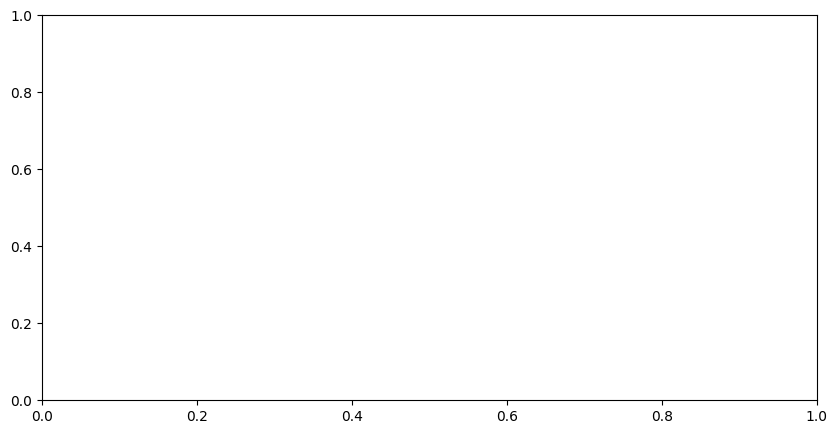

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

In [ ]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)